# Install Required Dependencies 

In [1]:
# Upgrade transformers to satisfy kaggle-environments
!pip install --upgrade transformers

# Downgrade torch and install compatible torchvision
!pip install torch==2.0.1 torchvision==0.15.2

# Resolve ydata-profiling conflicts
!pip install scipy==1.10.1
!pip install --upgrade typeguard
# Alternatively, upgrade ydata-profiling
# !pip install --upgrade ydata-profiling

# Install other required packages
!pip install unidecode tensorflow-addons datasets

# Restart the kernel after installations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 59.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 87.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# BERT Model
## 1) Import Necessary Dependencies and use GPU

In [2]:
# Install necessary packages

# Import libraries
import torch
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset
device = torch.device("cuda") 

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


## 2) Data Pre-processing

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define text cleaning functions
def remove_non_alphanum(string):
    if isinstance(string, str):
        string = unidecode(string)
        string = re.sub(r'[^a-zA-Z0-9\s]', '', string)
    return string

def lowercase_and_remove_stopwords(string):
    words = string.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Load the data
train = pd.read_csv('/kaggle/input/movie-plots/train.txt', 
                    delimiter='\t', 
                    names=["Title", "Industry", "Genre", "Director", "Plot"])
test = pd.read_csv('/kaggle/input/movie-plots/test_no_labels.txt', 
                   delimiter='\t', 
                   names=["Title", "Industry", "Director", "Plot"])

# Clean the 'Plot' and 'Director' columns
for df in [train, test]:
    df['Plot'] = df['Plot'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)
    df['Director'] = df['Director'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3) Check Class Imbalance

In [4]:
# Check for class imbalance
genre_counts = train['Genre'].value_counts()
print("Genre counts in training data:")
print(genre_counts)

Genre counts in training data:
Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64


## 4) Prepare Data

### a. Split Data into Training, Validation and Test Subsets

In [5]:
def split_data(data):
    # Use only the first 100 samples for faster execution
    train_data, tmp_data = train_test_split(
        data, 
        test_size=0.2, 
        shuffle=True,
        random_state=42
    )

    validation_data, test_data = train_test_split(
        tmp_data, 
        test_size=0.5, 
        shuffle=True,
        random_state=42
    )
    return train_data, validation_data, test_data

train_data, val_data, test_data = split_data(train)

### b. Encode Labels and Directors

In [6]:
# Encode genres
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['Genre'])
val_data['label'] = label_encoder.transform(val_data['Genre'])
test_data['label'] = label_encoder.transform(test_data['Genre'])

## 5) Tokenization

In [7]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'additional_special_tokens': ['[DIRECTOR]']})

# Function to tokenize data
def tokenize_function(examples):
    director_names = [f"[DIRECTOR] {director}" for director in examples['Director']]
    texts_with_directors = [f"{director_name} {text}" for director_name, text in zip(director_names, examples['Plot'])]
    return tokenizer(texts_with_directors, padding='max_length', truncation=True, max_length=512)

# Prepare the datasets for Hugging Face
train_dataset = Dataset.from_pandas(train_data[['Plot', 'Director', 'label']])
val_dataset = Dataset.from_pandas(val_data[['Plot', 'Director', 'label']])
test_dataset = Dataset.from_pandas(test_data[['Plot', 'Director', 'label']])

# Apply the tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/6432 [00:00<?, ? examples/s]

Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

## 6) Define the model

In [8]:
import torch.nn as nn

# Define the model class
class DistilBertForGenreClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertForGenreClassification, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Get BERT output
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token output
        # Get logits from classifier
        logits = self.classifier(pooled_output)
        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits}


## 7) Instantiate and Train the Model

In [19]:
from sklearn.metrics import f1_score

# Instantiate the model
num_labels = len(label_encoder.classes_)
model = DistilBertForGenreClassification(num_labels=num_labels)
model.bert.resize_token_embeddings(len(tokenizer))
# model = model.to(device)

# Check if the model's parameters are on the GPU
#for param in model.parameters():
    #print(param.device)
    
    
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=10,  # Reduced for faster execution
    # per_device_train_batch_size=4,  # Adjust batch size as needed
    # per_device_eval_batch_size=4,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to=[],
)

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = (predictions == labels).mean()
    
    # Calculate F1 score
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {'accuracy': accuracy, 'f1': f1}

# Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.887500,0.914046,0.675373,0.667658
2,0.730700,0.821712,0.715174,0.708589
3,0.439800,1.023827,0.686567,0.679618
4,0.115800,1.285399,0.707711,0.704071


TrainOutput(global_step=3216, training_loss=0.6439914551021447, metrics={'train_runtime': 761.4706, 'train_samples_per_second': 84.468, 'train_steps_per_second': 10.559, 'total_flos': 0.0, 'train_loss': 0.6439914551021447, 'epoch': 4.0})

## 8) Evaluate the Model on the Test Subset

In [21]:
# Evaluate the model's performance on the test data
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.8478500247001648, 'eval_accuracy': 0.7217391304347827, 'eval_f1': 0.7180519233347123, 'eval_runtime': 7.5015, 'eval_samples_per_second': 107.312, 'eval_steps_per_second': 13.464, 'epoch': 4.0}


## 9) Make Predictions on the Test Subset, Calculate Metrics and Plot Confusion Matrix

Classification Report with Accuracy per Genre:

           precision  recall  f1-score  accuracy  support
action        0.6136  0.7864    0.6894    0.7864      103
animation     0.9130  0.7636    0.8317    0.7636       55
comedy        0.7053  0.6204    0.6601    0.6204      108
crime         0.6957  0.6400    0.6667    0.6400       50
drama         0.6503  0.7083    0.6781    0.7083      168
horror        0.8803  0.8583    0.8692    0.8583      120
romance       0.7069  0.4824    0.5734    0.4824       85
sci-fi        0.5455  0.6667    0.6000    0.6667       18
western       0.8962  0.9694    0.9314    0.9694       98


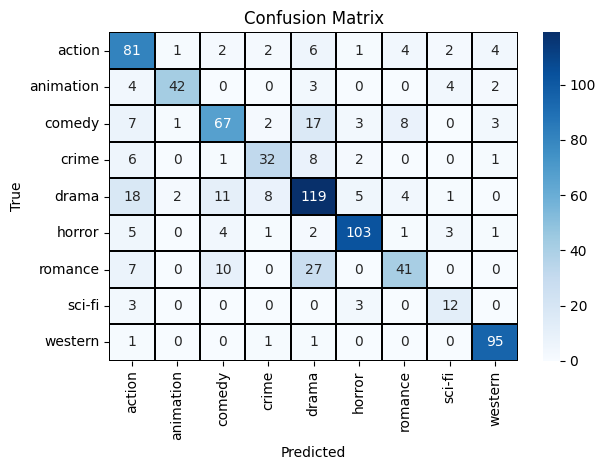

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Obtain predictions from the model
predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions

# Step 2: Interpret predictions
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_classes = label_encoder.inverse_transform(predicted_class_indices)

# True labels
true_class_indices = test_dataset['label']
true_classes = label_encoder.inverse_transform(true_class_indices)

cm = confusion_matrix(true_classes, predicted_classes, labels=label_encoder.classes_)

def plot_confusion_matrix(y_true, y_pred, cm):
    # Display the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='black', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("BERT_cm")

plot_confusion_matrix(y_true = true_classes, y_pred=predicted_classes, cm=cm)

# Initialize lists to hold metrics
precision_list = []
recall_list = []
f1_score_list = []
support_list = []
accuracy_list = []

total_samples = len(true_classes)

for i, genre in enumerate(label_encoder.classes_):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = total_samples - (TP + FP + FN)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0  # Per-genre accuracy as per your definition
    support = TP + FN  # Actual instances of the genre
    
    # Append metrics to lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    accuracy_list.append(accuracy)
    support_list.append(support)

# Create a DataFrame with the metrics
report_df = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1-score': f1_score_list,
    'accuracy': accuracy_list,
    'support': support_list
}, index=label_encoder.classes_)

# Round the metrics for better readability
report_df = report_df.round(4)

# Print the report
print("Classification Report with Accuracy per Genre:\n")
print(report_df)

## 10) Predict on the Unlabled Test Set

In [13]:
# Prepare the unlabeled test data
unlabeled_test = test.copy()  # Assuming 'test' is your test_no_labels.txt data

# Since we don't have labels, we can use the same process without labels
unlabeled_test_dataset = Dataset.from_pandas(unlabeled_test[['Plot', 'Director']])

# Tokenize the data
unlabeled_test_dataset = unlabeled_test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
unlabeled_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Get predictions
def test_sample_unlabeled(test_dataset, model):
    # Set model to evaluation mode
    model.eval()
    model.to(device)  # Move model to device
    
    # Use DataLoader for batching
    from torch.utils.data import DataLoader
    test_dataloader = DataLoader(test_dataset, batch_size=4)
    
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)        # Move input_ids to device
            attention_mask = batch['attention_mask'].to(device)  # Move attention_mask to device
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            preds = torch.softmax(logits, dim=1)
            
            # Move predictions to CPU and convert to numpy
            predictions.extend(preds.cpu().numpy())
    return np.array(predictions)


unlabeled_predictions = test_sample_unlabeled(unlabeled_test_dataset, model)

# Decode predictions to labels
unlabeled_predicted_class_indices = np.argmax(unlabeled_predictions, axis=1)
unlabeled_predicted_classes = label_encoder.inverse_transform(unlabeled_predicted_class_indices)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

## 11) Save the Results of the FInal Predictions

In [14]:
# Write predictions to a text file
with open('results.txt', 'w') as f:
    for idx, pred_label in enumerate(unlabeled_predicted_classes):
        if idx < len(unlabeled_predicted_classes) - 1:
            f.write(f"{pred_label}\n")  # Add newline for all but the last element
        else:
            f.write(f"{pred_label}")  # Write last element without newline